In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.optimize

from datetime import datetime
import pytz

import copy

import gm2
import trfp

Welcome to JupyROOT 6.12/04


In [2]:
station_phi = copy.copy(trfp.STATION_BARCODE_PHI)
station_edges = copy.copy(trfp.STATION_BARCODE_EDGES)

station_edges_6_probe = copy.copy(trfp.STATION_BARCODE_EDGES)

# need to step through all stations
# if station is a 4-probe station, change both its edge to its phi position

for st in range(72):
    if len(trfp.STATION_PROBE_ID[st]) == 4:
        station_edges_6_probe[st] = station_phi[st]
        station_edges_6_probe[st+1] = station_phi[st]
station_edges_6_probe[0] = station_phi[71]

# print station_edges
# print station_edges_6_probe


In [3]:
def trolley_run_station_average(corrected_df):

    # tr_phi is not monotonic, so sort by tr_phi

    corrected_df = corrected_df.sort_values(by=['tr_phi'])

    measured_phi = corrected_df['tr_phi'].values
    measured_extent = (np.roll(measured_phi,-1)-np.roll(measured_phi,1))/2
    measured_extent[0] = measured_extent[0]+180
    measured_extent[-1] = measured_extent[-1]+180
    # print np.max(measured_extent)

    corrected_df['tr_extent'] = pd.Series(measured_extent, index=corrected_df.index)
    corrected_df = corrected_df.sort_index()

    # for a given station:
    # create a mask for when trolley is in [low edge, high edge)
    tr_baseline = np.empty([72,17])
    fp_baseline = np.empty([72,6])
    summed_azimuth = np.empty(72)
    summed_pts = np.empty(72)
    baseline_time = np.empty(72)
    summed_azimuth_6_probe = np.empty(72)
    baseline_time_6_probe = np.empty(72)
    tr_baseline[:] = np.nan
    fp_baseline[:] = np.nan
    summed_azimuth[:] = np.nan
    summed_pts[:] = np.nan
    baseline_time[:] = np.nan
    summed_azimuth_6_probe[:] = np.nan
    baseline_time_6_probe[:] = np.nan

    for st in range(72):
        
        # first do m1-4 for all stations
        
        if station_edges[st+1] > station_edges[st]:
            mask = (corrected_df['tr_phi'] >= station_edges[st]) & (corrected_df['tr_phi'] < station_edges[st+1])
        else:  # case where we go over the 360 deg line
            mask = (corrected_df['tr_phi'] >= station_edges[st]) | (corrected_df['tr_phi'] < station_edges[st+1])

        out_df = corrected_df[mask]
        summed_pts[st] = out_df.shape[0]
        summed_azimuth[st] = sum(out_df['tr_extent'].values)        
        baseline_time[st] = sum(out_df.index.values)/summed_pts[st]

        for m in range(4):
            st_id = 'tr,m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)
            else:
                tr_baseline[st, m] = np.nan
        for m in range(4):
            st_id = 'st'+str(st)+',m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                fp_baseline[st, m] = np.mean(out_df[st_id])
            else:
                fp_baseline[st, m] = np.nan
                
        # next do m5+ for all stations
        
        if station_edges[st+1] > station_edges[st]:
            mask = (corrected_df['tr_phi'] >= station_edges_6_probe[st]) & (corrected_df['tr_phi'] < station_edges_6_probe[st+1])
        else:  # case where we go over the 360 deg line
            mask = (corrected_df['tr_phi'] >= station_edges_6_probe[st]) | (corrected_df['tr_phi'] < station_edges_6_probe[st+1])
        
        if len(trfp.STATION_PROBE_ID) != 4:
            out_df = corrected_df[mask]
            summed_pts[st] = out_df.shape[0]
            summed_azimuth_6_probe[st] = sum(out_df['tr_extent'].values)        
            baseline_time_6_probe[st] = sum(out_df.index.values)/summed_pts[st]
        else:
            summed_azimuth_6_probe[st] = np.nan
            baseline_time_6_probe[st] = np.nan

        for m in range(4,17):
            st_id = 'tr,m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                tr_baseline[st, m] = sum(out_df['tr_extent'].values*out_df[st_id].values)/sum(out_df['tr_extent'].values)
            else:
                tr_baseline[st, m] = np.nan
        for m in range(4,6):
            st_id = 'st'+str(st)+',m'+str(m+1)
            if sum(out_df['tr_extent'].values) != 0:
                fp_baseline[st, m] = np.mean(out_df[st_id])
            else:
                fp_baseline[st, m] = np.nan
    
    return tr_baseline, fp_baseline, baseline_time, summed_azimuth, baseline_time_6_probe, summed_azimuth_6_probe

In [4]:
def remove_trolley_effect(trolley_moment_df):
    '''DOC STRING'''
    barcode = station_phi
    
    veto_extent = 25

    trolley_effect_removed_df = trolley_moment_df.copy()

    for st in range(72):
        print '\rRemoving trolley image from station ' + str(st) + '.',
        for m in range(1,7):
            st_m = 'st' + str(st) + ",m" + str(m)

            # Unwrap the fixed probe data versus trolley position
            raw_data = trolley_moment_df[['tr_phi', st_m]].copy()
            raw_low = raw_data.copy()
            raw_high = raw_data.copy()
            raw_low['tr_phi'] = raw_low['tr_phi'] - 360
            raw_high['tr_phi'] = raw_high['tr_phi'] + 360
            unwrap_nomask_df = pd.concat([raw_low, raw_data, raw_high])

            unwrap_mask_df = unwrap_nomask_df.copy()
            veto_adjust = (veto_extent-7)/2
            mask = ((unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust-360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust-360) |
                    (unwrap_nomask_df['tr_phi']>barcode[st]-2-veto_adjust+360) & (unwrap_nomask_df['tr_phi']<barcode[st]+5+veto_adjust+360))
            unwrap_mask_df[st_m] = unwrap_nomask_df[st_m].mask(mask)
            unwrap_mask_df['tr_phi'] = unwrap_nomask_df['tr_phi']

            unwrap_filled_df = unwrap_mask_df.copy()
            temp = unwrap_filled_df.rolling(int(500),win_type='triang',min_periods=1,center=True).mean()
            temp = temp.rolling(int(500),win_type='triang',min_periods=1,center=True).mean()
            unwrap_filled_df[st_m] = unwrap_filled_df[st_m].mask(mask, temp[st_m])

            length = raw_data.shape[0]
            filled_df = unwrap_filled_df.iloc[length:2*length,:]

            trolley_effect_removed_df[st_m] = filled_df[st_m]

    print '\rFinished removing trolley images from ' + str(length) + ' events.'
    return trolley_effect_removed_df

In [5]:
corrected_df_1 = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3956_moment_df'))
tr_baseline_1, fp_baseline_1, baseline_time_1, summed_azimuth_1, baseline_time_6_probe_1, summed_azimuth_6_probe_1 = trolley_run_station_average(corrected_df_1)

corrected_df_2 = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_2.h5', key='run_3997_moment_df'))
tr_baseline_2, fp_baseline_2, baseline_time_2, summed_azimuth_2, baseline_time_6_probe_2, summed_azimuth_6_probe_2 = trolley_run_station_average(corrected_df_2)

# load all fixed probe runs moment_df into one big moment_df (runs 3959--3994)
print 'Appending fixed probe runs.'
fp_moment_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_3959_moment_df')
pts = fp_moment_df.shape[0]
for run in np.arange(3959, 3995):
    temp_df = pd.read_hdf('60hr_fixed_probe_runs.h5', key='run_'+str(run)+'_moment_df')
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    fp_moment_df = fp_moment_df.append(temp_df)

# load all the trolley runs corrected_df into on big file (to show window of 60hr set) ()
print '\nAppending trolley runs.'
tr_corrected_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_3955_moment_df'))
for run in np.arange(3956, 3959):
    temp_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_1.h5', key='run_'+str(run)+'_moment_df'))
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    tr_corrected_df = tr_corrected_df.append(temp_df)
for run in np.arange(3995, 3999):
    temp_df = remove_trolley_effect(pd.read_hdf('60hr_trolley_runs_2.h5', key='run_'+str(run)+'_moment_df'))
    pts = pts + temp_df.shape[0]
    print '\rAppending run ' + str(run) + '.',
    tr_corrected_df = tr_corrected_df.append(temp_df)

print '\nDone appending runs.'

Finished removing trolley images from 4382 events.                                                            


/home/aetb/.local/lib/python2.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in double_scalars


Finished removing trolley images from 4359 events.                                                            
Appending fixed probe runs.
Appending run 3994.                                  
Appending trolley runs.
Finished removing trolley images from 893 events.                          
Finished removing trolley images from 4382 events.                                                            
Finished removing trolley images from 2977 events.                                                            
Finished removing trolley images from 539 events.              
Finished removing trolley images from 365 events.            
Finished removing trolley images from 921 events.                          
Finished removing trolley images from 4359 events.                                                            
Finished removing trolley images from 2853 events.                                                            
Appending run 3998. 
Done appending runs.


In [6]:
### Apply baseline corrections, generate virtual trolley measurements

fp_moment_baseline = fp_moment_df.copy()
fp_moment_tr_run_baseline = tr_corrected_df.copy()

# apply baseline corrections to each fp stm
print "\nSubtracting fixed probe baselines."
for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        stm = 'st'+str(st)+',m'+str(m+1)

        def backwards_correction(time):
            c1 = fp_baseline_1[st, m]
            c2 = fp_baseline_2[st, m]
            if m < 4:
                t1 = baseline_time_1[st]
                t2 = baseline_time_2[st]
            else:
                t1 = baseline_time_6_probe_1[st]
                t2 = baseline_time_6_probe_2[st]
            return (c2-c1)/(t2-t1)*(time-t1) + c1

        correction = backwards_correction(fp_moment_baseline.index.values)
        fp_moment_baseline[stm] = fp_moment_baseline[stm] - correction
        correction = backwards_correction(fp_moment_tr_run_baseline.index.values)
        fp_moment_tr_run_baseline[stm] = fp_moment_tr_run_baseline[stm] - correction

        print '\rstm: ' + stm + '.',

# replace columns in vtr with Jacobian-fixed columns from fp baseline correction

print "\n\nApplying Jacobian."
vtr_df = fp_moment_df.copy()
vtr_tr_run_df = tr_corrected_df.copy()

for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    if num_probes == 4:
        num_moments = 4
        if st == 41:
            J = trfp.J_4_PROBE_ST41
        elif st == 37 | st == 39:
            J = trfp.J_4_PROBE_ST37_ST39
        else:
            J = trfp.J_4_PROBE
    else:
        num_moments = 5
        if st < 7:
            J = trfp.J_6_PROBE_OFFSET
        else:
            J = trfp.J_6_PROBE
    # run over each vtr moment:
    for m in np.arange(num_moments):
        vtr_stm = 'st'+str(st)+',m'+str(m+1)
        fp_stm = ['st'+str(st)+',m'+str(fp_m+1) for fp_m in np.arange(num_moments)]
        vtr_df[vtr_stm] = fp_moment_baseline[fp_stm].dot(J[m])
        vtr_tr_run_df[vtr_stm] = fp_moment_tr_run_baseline[fp_stm].dot(J[m])

        print '\rstm: ' + stm + '.',

# Add trolley baseline correction (with backwards correction)
print "\n\nAdding trolley baselines."

for st in np.arange(72):
    num_probes = len(trfp.STATION_PROBE_ID[st])
    for m in np.arange(num_probes):
        stm = 'st'+str(st)+',m'+str(m+1)

        def backwards_correction(time):
            c1 = tr_baseline_1[st, m]
            c2 = tr_baseline_2[st, m]
            if m < 4:
                t1 = baseline_time_1[st]
                t2 = baseline_time_2[st]
            else:
                t1 = baseline_time_6_probe_1[st]
                t2 = baseline_time_6_probe_2[st]
            return (c2-c1)/(t2-t1)*(time-t1) + c1

        correction = backwards_correction(vtr_df.index.values)
        vtr_df[stm] = vtr_df[stm] + correction
        correction = backwards_correction(vtr_tr_run_df.index.values)
        vtr_tr_run_df[stm] = vtr_tr_run_df[stm] + correction

        print '\rstm: ' + stm + '.',

print '\n\nDone.'

# bin into the agreed upon bins

bins = np.arange(1524384055, 1524641055, 1000)-500
bin_centers = np.arange(1524384055, 1524640055, 1000)

    # bins = np.arange(1524383560, 1524640850, 10)-5
# bin_centers = np.arange(1524383560, 1524640840, 10)

vtr_time_bin_df = vtr_df.groupby(pd.cut(vtr_df.index,bins)).mean()
vtr_time_bin_df.index = bin_centers
vtr_time_bin_df.head()


# print vtr_time_bin_df.iloc[[0,-1]]
# print vtr_time_bin_df.shape
# print bin_centers.shape

test_df = vtr_time_bin_df.copy()

azi_avg_df = pd.DataFrame(np.zeros((test_df.shape[0],6)),
                         index = test_df.index,
                         columns = ['m' + str(m) for m in np.arange(6)+1])

weight = summed_azimuth_1+summed_azimuth_2
total_weight = np.sum(weight)
for m in range(4):
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = test_df[stm_list].multiply(weight).sum(axis=1)/total_weight

weight = summed_azimuth_6_probe_1+summed_azimuth_6_probe_2
total_weight = np.sum(weight)
for m in range(4,6):
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    azi_avg_df['m'+str(m+1)] = test_df[stm_list].multiply(weight).sum(axis=1)/total_weight


Subtracting fixed probe baselines.
stm: st71,m4.    

Applying Jacobian.
stm: st71,m4.            

Adding trolley baselines.
stm: st71,m4.     

Done.


In [11]:
azi_avg_df.head()

,m1,m2,m3,m4,m5,m6
1524384055,52009.861724,3.529882,9.701554,17.686053,-72.256186,313.203337
1524385055,52009.937072,4.148464,9.733755,17.678139,-72.256146,313.180860
1524386055,52009.945778,4.366314,9.802921,17.662628,-72.222749,313.298327
1524387055,52009.405966,4.270919,9.795493,17.669938,-72.655273,313.262764
1524388055,52009.840066,4.616974,9.818404,17.688150,-72.521758,313.413522


In [10]:
review_df = azi_avg_df[['m1', 'm2', 'm3', 'm5']].copy()

review_df['m1_unc'] = 0.116
review_df['m2_unc'] = 0.060
review_df['m3_unc'] = 0.062
review_df['m5_unc'] = 0.100

review_df['m1'] = review_df['m1']/61.79
review_df['m2'] = review_df['m2']/61.79
review_df['m3'] = review_df['m3']/61.79
review_df['m5'] = review_df['m5']/61.79

review_df = review_df.reindex(sorted(review_df.columns), axis=1)


# review_df.to_csv('purcell_may27_fixed_m5.csv', float_format='%0.4f', index_label='time')

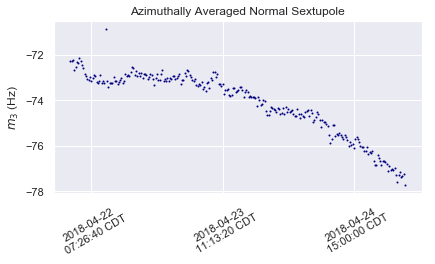

In [10]:
# Plotting parameters (maybe define standard functions based on these reqs later?)

matplotlib.rc('xtick', labelsize=8)     
matplotlib.rc('ytick', labelsize=8)
matplotlib.rc('axes', titlesize=16)
matplotlib.rc('axes', labelsize=12)
plt.rcParams["font.family"] = "serif"
sns.set(style="darkgrid")

single_column_small = (6.202, 3.833)  #inches
single_column_med = (6.202, 6.202)
single_column_large = (6.202, 7.666)

def plt_unix_time_to_CST(ax):
    plt.locator_params(axis='x', nbins=5)
    xticks = ax.get_xticks()
    ax.set_xticklabels([pd.to_datetime(tm, unit='s').tz_localize('UTC').tz_convert('US/Central').strftime('%Y-%m-%d\n %H:%M:%S %Z')
                          for tm in xticks], rotation=30)

def plt_set_labels(ax, x_label, y_label, title):
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)

# fig:final_nsext
fig4,ax4 = plt.subplots(1,1)
plt.rcParams["font.family"] = "serif"
plt.plot(azi_avg_df.index.values, azi_avg_df['m5'], '.', color='navy', markersize=2)
# ax4.set_ylim(-60,-40)
plt_unix_time_to_CST(ax4)
plt_set_labels(ax4, '', '$m_3$ (Hz)', 'Azimuthally Averaged Normal Sextupole')

fig4.set_size_inches(single_column_small)
fig4.tight_layout()
fig4.savefig('final_nsext.png', dpi=300)